In [ ]:
# default_exp fit

From https://people.duke.edu/~ccc14/sta-663/CalibratingODEs.html

In [ ]:
#export
import lmfit

# Parameter Fitting (using lmfit)

In [ ]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
from pyndamics3 import Simulation

pyndamics3  version  0.0.4


In [ ]:
#export
import numpy as np
from lmfit import minimize, Parameters, report_fit


[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 10
    # variables        = 3
    chi-square         = 6.57109651
    reduced chi-square = 0.93872807
    Akaike info crit   = 1.80095622
    Bayesian info crit = 2.70871150
[[Variables]]
    x0:  11.0567925 +/- 0.96541444 (8.73%) (init = 11.07915)
    a:   4.53818067 +/- 1.98778127 (43.80%) (init = 1)
    b:   1.07286655 +/- 0.41480929 (38.66%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(a, b)  =  0.983
    C(x0, b) =  0.272
    C(x0, a) =  0.248


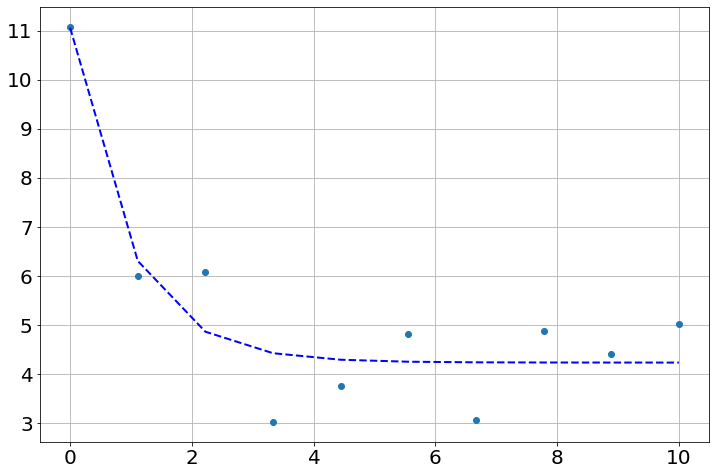

In [ ]:
from scipy.integrate import odeint

def f(xs, t, ps):
    """Receptor synthesis-internalization model."""
    try:
        a = ps['a'].value
        b = ps['b'].value
    except:
        a, b = ps
    x = xs

    return a - b*x

def g(t, x0, ps):
    """
    Solution to the ODE x'(t) = f(t,x,k) with initial condition x(0) = x0
    """
    x = odeint(f, x0, t, args=(ps,))
    return x

def residual(ps, ts, data):
    x0 = ps['x0'].value
    model = g(ts, x0, ps)
    return (model - data).ravel()

a = 2.0
b = 0.5
true_params = [a, b]
x0 = 10.0


t = np.linspace(0, 10, 10)
data = g(t, x0, true_params)
data += np.random.normal(size=data.shape)

# set parameters incluing bounds
params = Parameters()
params.add('x0', value=float(data[0]), min=0, max=100)
params.add('a', value= 1.0, min=0, max=10)
params.add('b', value= 1.0, min=0, max=10)

# fit model and find predicted values
result = minimize(residual, params, args=(t, data), method='leastsq')
final = data + result.residual.reshape(data.shape)

# plot data and fitted curves
plot(t, data, 'o')
plot(t, final, '--', linewidth=2, c='blue');

# display fitted statistics
report_fit(result)

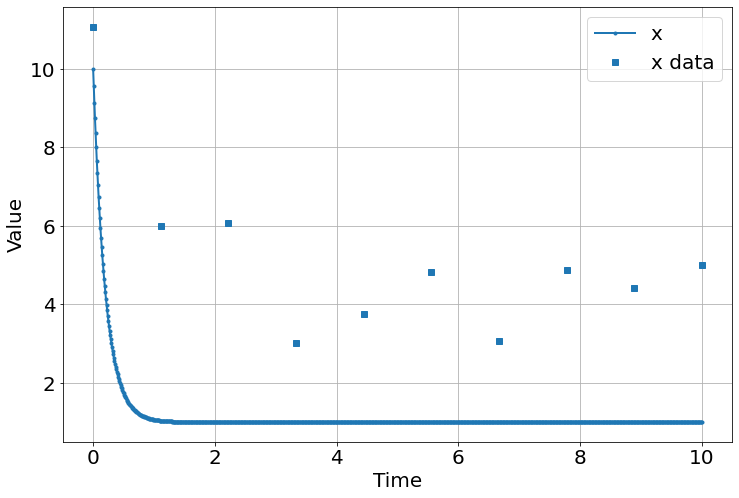

<Figure size 864x576 with 0 Axes>

In [ ]:
sim=Simulation()
sim.add("x'=a-b*x",10,plot=True)
sim.add_data(t=t,x=data,plot=True)
sim.params(a=5.,b=5)
sim.run(10)


In [ ]:
#export
def Parameter(name,**kwargs):
    from lmfit import Parameters
    params = Parameters()
    params.add(name, **kwargs)
    
    return params


In [ ]:
#export
def residual(ps, sim):
    
    params={}
    for key in ps.keys():
        if key.startswith('initial_'):
            name=key.split('initial_')[1]
            _c=sim.get_component(name)
            _c.initial_value=ps[key].value
            
        else:
            params[key]=ps[key].value
            
    sim.params(**params)
    
    # run the sim
    sim.run_fast()
    
    # compare with data
    values=[]
    for _c in sim.components:
        if not _c.data:
            continue
        t=np.array(_c.data['t']).ravel()
        y=np.array(_c.data['value']).ravel()
        y_fit=sim.interpolate(t,_c.name)

        if any(np.isnan(y_fit)):
            return -np.inf

        if any(abs(y_fit)>1e100):
            return -np.inf


        values.append(y-y_fit)

    return np.concatenate(values).ravel()
    

def fit(sim,
       *args,method='leastsq'):
    
    from lmfit import Parameters,minimize
    
    fitparams=Parameters()
    for arg in args:
        fitparams+=arg
    
    for key in fitparams.keys():
        if key.startswith('initial_'):
            name=key.split('initial_')[1]
            try:
                _c=sim.get_component(name)
            except IndexError:
                raise ValueError("%s is a bad initial variable because %s is not a variable in the dynamical model." % (key,name))
        else:
            if not key in sim.original_params:
                raise ValueError("%s is not a parameter in the dynamical model.  Parameters are %s" % (key,str(sim.original_params)))

    
    result = minimize(residual, fitparams, args=(sim,), method=method)    
    
    params={}
    ps=result.params
    for key in ps.keys():
        if key.startswith('initial_'):
            name=key.split('initial_')[1]
            _c=sim.get_component(name)
            _c.initial_value=ps[key].value
            
        else:
            params[key]=ps[key].value
            
    sim.params(**params)
    
    
    return result



In [ ]:
results=fit(sim,
   Parameter('a',value=1,min=0),
   Parameter('b',value=5,min=0),
   Parameter('initial_x',value=10,min=0),
           method='nelder')

report_fit(result)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 10
    # variables        = 3
    chi-square         = 6.57109651
    reduced chi-square = 0.93872807
    Akaike info crit   = 1.80095622
    Bayesian info crit = 2.70871150
[[Variables]]
    x0:  11.0567925 +/- 0.96541444 (8.73%) (init = 11.07915)
    a:   4.53818067 +/- 1.98778127 (43.80%) (init = 1)
    b:   1.07286655 +/- 0.41480929 (38.66%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(a, b)  =  0.983
    C(x0, b) =  0.272
    C(x0, a) =  0.248


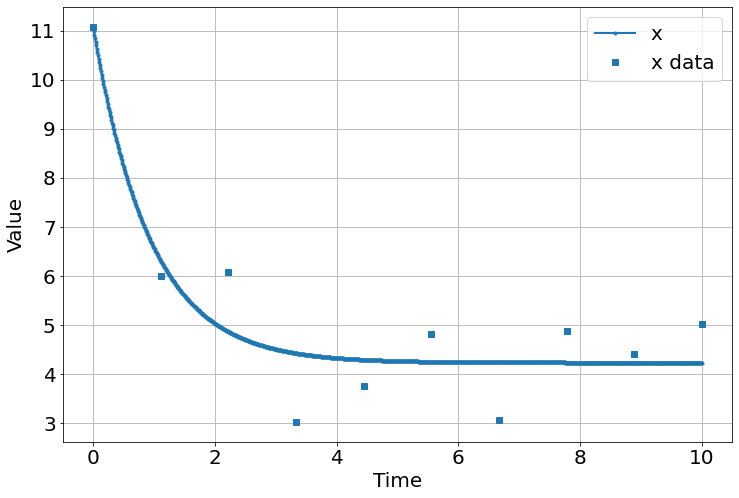

<Figure size 864x576 with 0 Axes>

In [ ]:
sim.run(10)

In [ ]:
residual(result.params,sim)

array([ 0.02234836, -0.3009205 ,  1.21600293, -1.40328144, -0.53647406,
        0.57232895, -1.16834485,  0.64644872,  0.17520793,  0.77665516])

In [ ]:
result

In [ ]:
a=result.params['a']

In [ ]:
a.stderr

1.987781269182456